### Download the STL10 tar.gz file and unzip it
*   Import useful libraries, download and unzip the STL10 data


In [ ]:
import urllib.request
import tarfile

# download the STL10 tar.gz file and unzip it
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

### Read the STL10 binary data and save the labeled images into train/test folders
*   Import necessary libraries
*   Create a path to the data directory
*   Read the data, and save train and test images

In [ ]:
filename = DATA_URL.split('/')[-1]
filepath, _ = urllib.request.urlretrieve(DATA_URL, filename)
tarfile.open(filepath, 'r:gz').extractall()

In [ ]:
import os, errno
import numpy as np
from imageio import imsave

# path to the directory including the binary data
DATA_PATH = './stl10_binary/'

# path to save images
SAVE_PATH = './img/'

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def save_images(images, labels, des_path):
    i = 0
    for image in images:
        label = labels[i]
        directory = os.path.join(des_path, str(label))
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = os.path.join(directory, str(i) + '.png')
        imsave(filename, image, format="png")
        i = i+1

In [ ]:
# read the binary data and save train images
phase = 'train'
images_train = read_all_images(DATA_PATH + phase + '_X.bin')
labels_train = read_labels(DATA_PATH + phase + '_y.bin')
save_images(images_train, labels_train, SAVE_PATH + phase)

# read the binary data and save test images
phase = 'test'
images_test = read_all_images(DATA_PATH + phase + '_X.bin')
labels_test = read_labels(DATA_PATH + phase + '_y.bin')
save_images(images_test, labels_test, SAVE_PATH + phase)

### Visualise some sample images

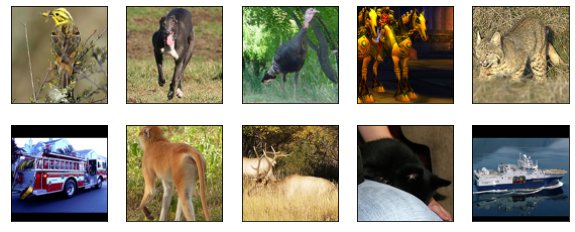

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    img = images_train[idx]
    plt.imshow(img)

### Model training and testing
*   Import useful libraries
*   Create dataloaders for training and testing images, batch_size = 64
*   Load and modify the pre-trained ResNet50 model
*   Train the model for 5 epochs
*   Evaluate the trained model
*   Count the number of mislabeled images in the weakest class and display a mislabeled image of the weakest class



In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline

Create dataloaders for training and testing images

In [ ]:
transform_train = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])

transform_test = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

data_dir_train = './img/train'
dataset_train = datasets.ImageFolder(data_dir_train, transform_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

data_dir_test = './img/test'
dataset_test = datasets.ImageFolder(data_dir_test, transform_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Load and modify the pre-trained ResNet50 model 

In [ ]:
# pretrained resnet50
model = models.resnet50(pretrained=True)
# replace the last fully-connected layer with a new one which has 10 output nodes 
model.fc = nn.Linear(2048, 10)
# move the model to current device
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# function for training, default number of epoches is 5.
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5, save_path='./model.pth'):
    since = time.time()
    model.train()    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.shape[0]
            running_corrects += torch.sum(preds==targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_average_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = running_corrects.float() / len(dataloader.dataset)
        print("Average loss: {:.4f}\tAccuracy: {:.4f}\n".format(epoch_average_loss, epoch_accuracy))
    
    time_elapsed = time.time() - since
    # print the training loss and accuracy for each epoch
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    torch.save(model.state_dict(), save_path)
    print('Model saved in {}'.format(save_path))

In [ ]:
train_model(model, dataloader_train, criterion, optimizer, device)

Epoch 1/5
----------
Average loss: 0.7253	Accuracy: 0.8748

Epoch 2/5
----------
Average loss: 0.1534	Accuracy: 0.9728

Epoch 3/5
----------
Average loss: 0.0851	Accuracy: 0.9844

Epoch 4/5
----------


In [ ]:
# read class names
f = open("./stl10_binary/class_names.txt")
class_names = f.read().split("\n")[:-1]
# dictionary mapping index to class name
idx_to_classname = {dataset_test.class_to_idx[cls]:class_names[int(cls)-1] for cls in dataset_test.class_to_idx}
print(idx_to_classname)

In [ ]:
from collections import defaultdict
# define a function to test the trained model on the test dataset
def test_model(model, dataloader, device):
    model.eval()
    # count images by class
    count_by_class = defaultdict(int)
    # count correctly predicted images by class
    count_correct_by_class = defaultdict(int)
    # count correctly predicted images in total
    count_correct_total = 0
    for inputs, targets in dataloader:
        # a batch of test images 
        inputs = inputs.to(device)
        # the classes(indexs) of this batch of test images
        targets = targets.to(device)
        # output of the trained model on this batch of test images
        outputs = model(inputs)
        # the predicted classes(indexs)
        _, preds = torch.max(outputs, 1)
        for target_idx, pred_idx in zip(targets, preds):
            # count this batch of test images by their true classes
            count_by_class[target_idx.item()] += 1
            # compare the predicted class and the true class of each test image
            if pred_idx == target_idx:
                # count the correctly predicted images by their classes
                count_correct_by_class[target_idx.item()] += 1
        # count the total correctly predicted images
        count_correct_total += torch.sum(preds==targets)

    total_accuracy = count_correct_total.float() / len(dataloader.dataset)
    print("{:<30} {:.4f}".format('Total accuracy:', total_accuracy))
    print('-'*40)
    print('Accuracy by class')
    accuracy_by_class = []
    for idx in range(10):
        accuracy_by_class.append(float(count_correct_by_class[idx])/count_by_class[idx])
        print("{:<30} {:.4f}".format(idx_to_classname[idx]+':', accuracy_by_class[idx]))
    print('-'*40)
    weakest_class_index = np.argmin(accuracy_by_class)
    print('So the weakest class is {}. index = {}.'.format(idx_to_classname[weakest_class_index], weakest_class_index))
    return weakest_class_index

In [ ]:
# run the test_model function
with torch.no_grad():
    weakest_class_index = test_model(model, dataloader_test, device)

In [ ]:
model.eval()
mislabeled = []
# locate the image folder of the weakest class
for dirname, _, filenames in os.walk('./img/test/' + str(weakest_class_index)):
    for filename in filenames:
        # open each image
        img = Image.open(os.path.join(dirname, filename))
        # transfer the images as an input to the trained model
        inputs = transform_test(img).unsqueeze(0).to(device)
        # output of the model
        output = model(inputs)
        # predicted class
        _, predicted_index = torch.max(output, 1)
        # compare the predicted and true class, count the image if it is mislabeled
        if predicted_index.item()!=weakest_class_index:
            mislabeled.append((os.path.join(dirname, filename), idx_to_classname[predicted_index.item()]))
print("There are {} mislabled {} images.".format(len(mislabeled), idx_to_classname[weakest_class_index]))

In [ ]:
# pick and display a mislabeled image of the weakest class
ii = 3
print("Path to this mislabeled image: {}\npredicted class: {}\nreal class: {}".format(mislabeled[ii][0],mislabeled[ii][1], idx_to_classname[weakest_class_index]))
img = Image.open(mislabeled[ii][0])
img.resize((224, 224))

### Inplementation of Grad-CAM

In [ ]:
import cv2
# The function implementing GRADCAM to visualize the layer activations
def GRADCAM(device, model, activation_layer, image, index=None):
    activations = []
    def hook(model, input, output):
        activations.append(output)
    hook_handler = model._modules[activation_layer].register_forward_hook(hook)
    input = transform_test(image).unsqueeze(0).to(device)
    if index == None:
        # By default, show the layer activations for the weakest class
        index = weakest_class_index
    output = model(input)[0][index]
    activations[0].retain_grad()
    output.backward()
    neuron_importance_weights = activations[0].grad.mean(dim=(2,3)).detach().cpu().numpy()
    feature_map_activations = activations[0].detach().cpu().numpy()
    hook_handler.remove()

    # initialize the gradcam and calculate it
    gradcam = np.zeros(feature_map_activations.shape[2:])
    for i in range(feature_map_activations.shape[1]):
        grad = neuron_importance_weights[0][i]
        map = feature_map_activations[0][i]
        gradcam += grad * map

    # clip the nagetive values
    gradcam = np.maximum(gradcam, 0)
    # resize the gradcam to size (224, 224) 
    gradcam = cv2.resize(gradcam, (224, 224))

    # normalize the gradcam values to range (0, 1)
    gradcam = gradcam - np.min(gradcam)
    if np.max(gradcam) > 0:
        gradcam = gradcam / np.max(gradcam)

    # combine the heatmap and the input image(resize to 224x224), save the combined image
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    gradcam_image = heatmap + np.float32(image.resize((224, 224))) / 255
    gradcam_image = gradcam_image / np.max(gradcam_image)
    cv2.imwrite("gradcam.jpg", np.uint8(255 * gradcam_image))

In [ ]:
# pick and display a mislabeled image of the weakest class
ii = 3
print("Path to this mislabeled image: {}\npredicted class: {}\nreal class: {}".format(mislabeled[ii][0],mislabeled[ii][1], idx_to_classname[weakest_class_index]))
img = Image.open(mislabeled[ii][0])
img.resize((224, 224))

In [ ]:
# print the (index : class_name) pairs
print(idx_to_classname)

In [ ]:
# run the GRADCAM function for the weakest class: this time it is "dog, index=6"
GRADCAM(device, model, 'layer4', img, index=6)
gradcam_image = Image.open('./gradcam.jpg')
gradcam_image

## Model Improvement
### The model performance, without changing the number of epochs, can be improved with some of the following steps:

The training and test accuracies are 0.994 and 0.947 respectively after 5 epochs. Therefore;
1. Data augmentation can be used to reduce the overfitting. For example, the training images can be randomly flipped, rotated, and translated to improve the performance of the model.
2. Hyperparameters tuning - learning rate and batch size can be tuned to optimised model performance.
3. Use of other types of optimizers could improve the performance of the model as well.